# DDQN to Beat Mario

## Background

In 2013, DeepMind made the Deep Q Network to play Atari Games (https://arxiv.org/pdf/1312.5602.pdf). This DQN was able to learn to play simple Atari games at human level, kickstarting the past decade of DeepRL research.

In 2015, DeepMind published another paper which played even more Atari Games (https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). This new model included a target network to reduce Q-value overestimation in the previous DQN model. This model is sometimes called DDQNs, and it's what we'll implement here to beat Mario!

## Setup and Some Exploration

First, we install gymnasium and the Mario Env.

The Mario env can be found here: https://pypi.org/project/gym-super-mario-bros/

In [3]:
# uncomment if using colab; if running locally it's recommended to install via conda
!pip uninstall -y gym
!pip install gymnasium
!pip install gym_super_mario_bros==7.3.0
!pip install wandb

Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 33.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 51.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.4 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=494914 sha256=3807625128d778e533f42c

Before we transform the env with wrappers and make our agent, let's take a look at the environment as-is. Below we take some random actions and generate a video

In [4]:
import gymnasium as gym
from gym.wrappers import RecordVideo

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

import numpy as np

import warnings
warnings.filterwarnings('ignore')

env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", apply_api_compatibility=True, render_mode='rgb_array')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

def run_test(env, num_steps=50):
    frames = []
    out = env.reset()
    for _ in range(num_steps):
        next_state, reward, done, truncated, info = env.step(action=env.action_space.sample())
        frames.append(np.copy(env.render()))
    return frames

frames = run_test(env)

In [5]:
print(frames[-1].shape)

(240, 256, 3)


We can reuse the following code to see what our bot does later on:

In [6]:
from IPython.display import HTML
from base64 import b64encode
import numpy as np
import os
import cv2
from tqdm import tqdm

def display_vid(frames, vid_name='./video.mp4', compressed_name='./compressed.mp4', fps=30):

    if os.path.isfile(vid_name):
      !rm video.mp4
    if os.path.isfile(compressed_name):
      !rm compressed.mp4

    h, w, c = frames[-1].shape
    out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'VP90'), fps, (w, h))
    for frame in tqdm(frames):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        out.write(img)
    out.release()

    os.system(f"ffmpeg -i {vid_name} -vcodec libx264 {compressed_name}")

    mp4 = open(vid_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [7]:
display_vid(frames)

100%|██████████| 50/50 [00:00<00:00, 76.00it/s]


## Preprocessing Environment

The DeepMind papers for Atari games transforms the environments to make it easier for the DQN/DDQN to learn. In particular,

1. Use only every 4th frame
2. Grayscale each image, downscale to 110x84, then crop appropriately to remove unnecesssary info
3. Pass a stack of 4 frames so that the model can see trajectory (falling and jumping are different contexts, but may lead to the same observation).


We will implement some of these simplifying transformations using Gymnasium's `gym.Wrapper`. Wrapper code is altered from https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/.

In [8]:
import collections
import cv2

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._replay_buffer = collections.deque(maxlen=4)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            self._replay_buffer.append(obs.copy())
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, truncated, info

    def render(self, mode='rgb_array'):
        if mode == 'rgb_array':
            return self._replay_buffer
        
        return self.env.render(mode=mode)

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, observation):
        return ProcessFrame84.process(observation)

    @staticmethod
    def process(frame):
        assert frame.size == 240 * 256 * 3, "Unknown resolution."

        img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class TransposeObs(gym.ObservationWrapper):
    def __init__(self, env):
        super(TransposeObs, self).__init__(env)
        w, h, n = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(n, w, h), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self, **kwargs):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset()), {}

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation[0]
        return self.buffer

In [9]:
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import RIGHT_ONLY

def preprocessed_env():
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", apply_api_compatibility=True, render_mode='rgb_array')
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = TransposeObs(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

In [10]:
env = preprocessed_env()
print('obs space', env.observation_space.shape)
print('act space', env.action_space.n)

obs space (4, 84, 84)
act space 5


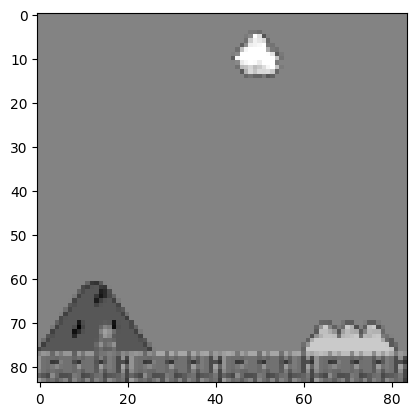

In [11]:
import matplotlib.pyplot as plt

plt.imshow(env.reset()[0][-1], cmap='gray')

We now have a preprocessed environment! We can proceed to working on our Agent.

## Building DDQN

The original DQN paper from 2013 uses the following algorithm:

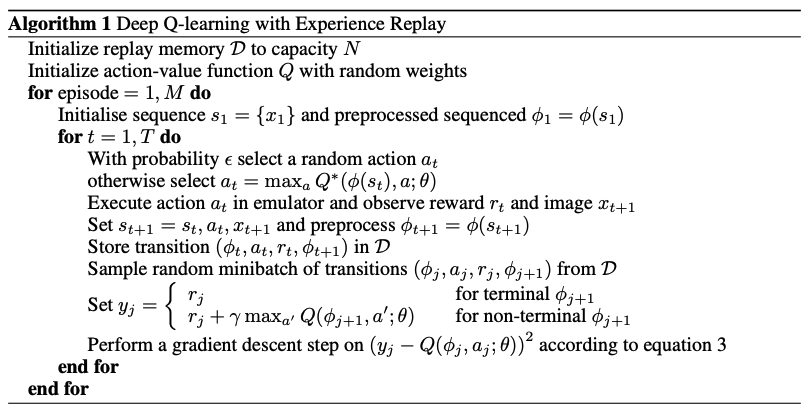

The 2015 paper updates the loss function to that pictured below to include a target network whose parameters, $\theta ^{-}_{i}$, are updated to the Q-network's parameters, $\theta_{i}$ every $C$ steps:

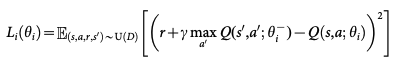

We will first build the solver architecture, then we will proceed to building the agent which implements the above algorithm.

The Q-Network and Target network in our DDQN share the following architecture:
1. Conv2d with 32 8x8 kernels, stride 4 + nonlinearlity (we will use ReLU)
2. Conv2d with 64 4x4 kernels, stride 2 + nonlinearity
3. Conv2d with 64 3x3 kernels, stride 1 + nonlinearity
3. FC layer with 512 nodes + nonlinearity
4. FC layer with # nodes equal to # actions (note this assumes a discrete action space)

We implement this with Pytorch:

In [12]:
import torch
import torch.nn as nn
import random
from pathlib import Path

In [13]:
class DQNNet(nn.Module):

    def __init__(self, obs_shape, n_actions):
        super(DQNNet, self).__init__()

        self.obs_shape = obs_shape

        self.conv = nn.Sequential(
            nn.Conv2d(self.obs_shape[0], 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        num_batches = x.size(0)

        x = self.conv(x)
        x = x.view(num_batches, -1)
        return self.fc(x)

Now, before we move on to making our Agent, we will build its memory. The memory will allow our agent to cache and sample experiences for Experience Replay.

In [14]:
class Memory:
    def __init__(self, state_space, batch_size, max_memory_size):

        # get device
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        # input dim vars
        self.state_space = state_space
        self.batch_size = batch_size
        self.max_memory_size = max_memory_size

        # save torch arrays for storing memories
        self.state_mem = torch.zeros(self.max_memory_size, *self.state_space)
        self.new_state_mem = torch.zeros(self.max_memory_size, *self.state_space)
        self.action_mem = torch.zeros(self.max_memory_size, 1)
        self.reward_mem = torch.zeros(self.max_memory_size, 1)
        self.done_mem = torch.zeros(self.max_memory_size, 1)
        
        # queue tracking variables
        self.ending_position = 0
        self.num_in_queue = 0

    # store experiences
    def cache(self, state, new_state, action, reward, done):

        # save torches in memory
        self.state_mem[self.ending_position] = state.float()
        self.new_state_mem[self.ending_position] = new_state.float()
        self.action_mem[self.ending_position] = action.float()
        self.reward_mem[self.ending_position] = reward.float()
        self.done_mem[self.ending_position] = done.float()

        # update queue tracking variables
        self.ending_position = (self.ending_position + 1) % self.max_memory_size
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)

    # sample a batch of experiences from memory
    def recall(self):
        
        # sample random choices uniformly with replacement
        idx = random.choices(range(self.num_in_queue), k=self.batch_size)
        
        # send to device
        state = self.state_mem[idx].to(self.device)
        new_state = self.new_state_mem[idx].to(self.device)
        action = self.action_mem[idx].to(self.device)
        reward = self.reward_mem[idx].to(self.device)
        done = self.done_mem[idx].to(self.device)
        
        return state, new_state, action, reward, done
    
    def __len__(self):
        return self.num_in_queue

Now we can build our agent! It will use `Memory` to cache experience and sample batches for experiences, and it will use `DQNNet` for the target and local networks.

We'll implement `act`, which handles exploration/exploitation, and `experience_replay`, which handles local network learning on a batch of experiences and transfering params to the target network.

In [15]:
class DQNAgent:

    def __init__(
            self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
            exploration_max, exploration_min, exploration_decay,
            transfer_every=5000,
            checkpoint_dir='./checkpoints', have_mem=True,
    ):
        
        # get device
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.cpu = torch.device('cpu')
        self.checkpoint_dir = checkpoint_dir

        # state and action space shapes
        self.state_space = state_space
        self.action_space = action_space

        # local and target nets
        self.local_net = DQNNet(state_space, action_space).to(self.device)
        self.target = DQNNet(state_space, action_space).to(self.device)
        
        # only need optimizer for local net. target net will have params transfered over
        self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
        self.l1 = nn.SmoothL1Loss().to(self.device)
        self.transfer_every = transfer_every
        self.step = 0

        # init memory
        # note, have_mem would be false for eval to save space
        if have_mem:
            self.max_memory_size = max_memory_size
            self.batch_size = batch_size
            self.mem = Memory(state_space, batch_size, max_memory_size)
        
        # Learning parameters
        self.gamma = gamma
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
    

    def act(self, state):
        
        self.step += 1

        # exploration
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        
        # exploitation
        state = state.to(self.device)
        optimal_action = torch.argmax(self.local_net(state))

        return optimal_action.unsqueeze(0).unsqueeze(0).to(self.cpu)

    # update target net params to local net
    def transfer_model(self):        
        self.target.load_state_dict(self.local_net.state_dict())

    def experience_replay(self):
        
        # transfer params to target net
        if self.step % self.transfer_every == 0:
            self.transfer_model()
        # if not enough experiences for a batch, ignore
        if self.batch_size > len(self.mem):
            return

        # zero out grads in local net
        self.optimizer.zero_grad()

        # get batch
        state, new_state, action, reward, done = self.mem.recall()
        
        # target update
        target = self.gamma * self.target(new_state).max(1).values.unsqueeze(1)
        target = reward + torch.mul(target, 1 - done) # note: if done step, no 'next' action

        # current from loval net
        current = self.local_net(state).gather(1, action.long())

        # backprop and descent
        loss = self.l1(current, target)
        loss.backward()
        self.optimizer.step()

        # update exploration rate
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)


    # save and load methods for checpointing
    def save(self, path='ddqn_mario.pt', save_mem=False):
        save_path = Path(self.checkpoint_dir) / Path(path)
        if save_mem:
            torch.save({
                'model': self.local_net.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'exploration_rate': self.exploration_rate,
                'state_mem': self.mem.state_mem,
                'new_state_mem': self.mem.new_state_mem,
                'action_mem': self.mem.action_mem,
                'reward_mem': self.mem.reward_mem,
                'done_mem': self.mem.done_mem,
            }, save_path)
        else:
            torch.save({
                'model': self.local_net.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'exploration_rate': self.exploration_rate,
            }, save_path)
    
    def load(self, path='ddqn_mario.pt'):
        checkpoint = torch.load(path, map_location=self.device)

        self.local_net.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])

        self.exploration_rate = checkpoint['exploration_rate']

        try:
            self.mem.state_mem = checkpoint['state_mem']
            self.mem.new_state_mem = checkpoint['new_state_mem']
            self.mem.action_mem = checkpoint['action_mem']
            self.mem.reward_mem = checkpoint['reward_mem']
            self.mem.done_mem = checkpoint['done_mem']
        except:
            print('No replay memory in this save')

## Training

In [16]:
def train(
    logging=False, log_init=False, wandb_proj='Mario-RL',
    ep_offset=0, pretrained_path=None, 
    num_episodes=10000, save_every=1000, avg_over = 500
):

    if logging and log_init:
        wandb.init(project=wandb_proj)
   
    env = preprocessed_env()

    agent = DQNAgent(
        state_space=env.observation_space.shape,
        action_space=env.action_space.n,
        max_memory_size=30000,
        batch_size=32,
        gamma=0.90,
        lr=0.00025,
        exploration_max=1.0,
        exploration_min=0.02,
        exploration_decay=0.99,
    )

    if pretrained_path != None:
        agent.load(pretrained_path)

    agent.local_net.train()

    env.reset()
    total_rewards = []
    
    for episode_num in tqdm(range(num_episodes)):
        ep_num = episode_num + ep_offset
        
        state, _ = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        
        while True:
            action = agent.act(state)
            steps += 1
            
            next_state, reward, terminal, truncated, info = env.step(int(action[0]))
            
            total_reward += reward

            next_state = torch.Tensor([next_state])
            action = torch.Tensor([action]).unsqueeze(0)
            reward = torch.tensor([reward]).unsqueeze(0)
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            agent.mem.cache(state, next_state, action, reward, terminal)
            agent.experience_replay()
            
            state = next_state

            if terminal:
                break
        
        total_rewards.append(total_reward)

        if (episode_num == num_episodes - 1) or (ep_num % save_every == 0):
            agent.save(path=f'ddqn_mario_{ep_num}.pt')

        if logging:
            avg_reward = 0
            if len(total_rewards) > avg_over:
                avg_reward = sum(total_rewards[:-avg_over]) / len(total_rewards[:-avg_over])
            else:
                avg_reward = sum(total_rewards) / len(total_rewards)
            wandb.log({
                'train/total_rewards': total_reward,
                f'train/avg_reward_last_{avg_over}': avg_reward,
                'train/exploration_rate': agent.exploration_rate,
                'train/ep_len': steps,
            }, step=ep_num)

        num_episodes += 1
    
    env.close()
    wandb.finish()

We are ready to train! Note that training this model can take a while, and you might need to tweak the input memory size if using a Colab environment.

We have a pretrained model checkpoint available here: https://drive.google.com/file/d/1hMyLJaEqf6eaO1zkKhQDM-DAeK_cUbpE/view?usp=share_link. Unfortunately we can't download this model straight from GDrive since it's too big for `gdown`.

To get around this, please download the model manually and upload below.

In [2]:
from google.colab import files

files.upload()

Saving acm_ai_ddqn_checkpoint.pt to acm_ai_ddqn_checkpoint (1).pt


For our pretrained model, 

In [1]:
from IPython.display import IFrame
IFrame('https://api.wandb.ai/links/arth-shukla/npvw4jhz', width=700, height=500)

In [6]:
IFrame('https://api.wandb.ai/links/arth-shukla/iyxem7bc', width=700, height=500)

If you'd like to train manually, please uncomment the below. You can optionally use wandb to log metrics.

In [18]:
# import wandb
# wandb.login()

# train(logging=True)

## Let's Watch Our Bot Play!

In [19]:
def run_level(pretrained_path=None):
    with torch.no_grad():
        frames = []
        
        env = preprocessed_env()

        agent = DQNAgent(
            state_space=env.observation_space.shape,
            action_space=env.action_space.n,
            max_memory_size=30000,
            batch_size=32,
            gamma=0.90,
            lr=0.00025,
            exploration_max=1.0,
            exploration_min=0.02,
            exploration_decay=0.99,
            have_mem=False
        )

        if pretrained_path != None:
            agent.load(pretrained_path)

        agent.local_net.eval()

        env.reset()

        state, _ = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0

        total_reward = 0
        while True:
            action = agent.act(state)
            steps += 1

            next_state, reward, terminal, truncated, info = env.step(int(action[0]))

            total_reward += reward

            state = torch.Tensor([next_state])
            
            for x in env.render():
                frames.append(x.copy())

            if terminal:
                break

        env.close()
        
        return frames

In [20]:
frames = run_level(pretrained_path='./acm_ai_ddqn_checkpoint.pt')

No replay memory in this save


Let's watch our DDQN play Mario! Note that it might still lose sometimes...

In [21]:
display_vid(frames, fps=60)

100%|██████████| 1132/1132 [00:34<00:00, 32.86it/s]
